# Experimental Orchestration Pipeline
## (With Tiling)

In [1]:
!pip install torch torchvision scikit-learn hdbscan plotly umap-learn opencv-python rasterio pycocotools

  Using cached hdbscan-0.8.40-cp312-cp312-linux_x86_64.whl
  Using cached umap_learn-0.5.9.post2-py3-none-any.whl.metadata (25 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached rasterio-1.4.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
  Using cached pycocotools-2.0.10-cp312-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.3 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
  Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1.2-py2.py3-none-any.whl.metadata (6.5 kB)
Using cached umap_learn-0.5.9.post2-py3-none-any.whl (90 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (67.0 MB)
U

In [1]:
import torch
import torchvision
import pytorch_lightning as pl
import numpy as np
import cv2
from PIL import Image
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import hdbscan
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from tqdm.notebook import tqdm
from pycocotools import mask as mask_util
import warnings
warnings.filterwarnings('ignore')

# Try importing rasterio for GeoTIFF support
try:
    import rasterio
    from rasterio.windows import Window
    RASTERIO_AVAILABLE = True
except ImportError:
    RASTERIO_AVAILABLE = False
    print("⚠ rasterio not available. GeoTIFF support limited. Install with: pip install rasterio")

<h2>Defining Functions </h2>

<h4>Configuration</h4>

In [2]:
@dataclass
class PipelineConfig:
    """Configuration for the tree crown pipeline"""
    # Paths
    image_path: str
    maskrcnn_checkpoint: str
    autoencoder_checkpoint: str
    output_dir: str = "outputs"
    
    # Image sizes
    original_size: int = 1024
    maskrcnn_size: int = 500
    autoencoder_size: int = 512
    
    # Detection thresholds
    mask_threshold: float = 0.5
    score_threshold: float = 0.5
    
    # Clustering
    clustering_method: str = "HDBSCAN"  # "DBSCAN" or "HDBSCAN"
    subset_ratio: float = 0.25  # Use 25% for parameter optimization
    
    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

@dataclass
class OrthomosaicConfig:
    """Configuration for orthomosaic processing pipeline"""
    # Paths
    orthomosaic_path: str
    maskrcnn_checkpoint: str
    autoencoder_checkpoint: str
    output_dir: str = "outputs/orthomosaic"
    
    # Tiling parameters
    tile_size: int = 1024
    tile_overlap_percent: int = 20  # 10-25%
    
    # Image sizes for models
    maskrcnn_size: int = 500
    autoencoder_size: int = 512
    
    # Detection thresholds
    mask_threshold: float = 0.5
    score_threshold: float = 0.5
    
    # Clustering
    clustering_method: str = "HDBSCAN"  # "DBSCAN" or "HDBSCAN"
    subset_ratio: float = 0.25
    
    # Duplicate merging
    iou_threshold: float = 0.5
    
    # Visualization
    preview_max_size: int = 2048  # Downsample to this for preview
    enable_tile_previews: bool = True  # Show tiles as they're processed
    
    # Processing
    batch_tiles: int = 1  # Process N tiles at once (increase if more RAM available)
    save_intermediate: bool = True  # Save per-tile results
    
    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


<h4>Model Loading</h4>

In [3]:
class PredictionProcessor:
    """Process Mask R-CNN predictions"""
    def __init__(self, mask_threshold=0.5, score_threshold=0.5):
        self.mask_threshold = mask_threshold
        self.score_threshold = score_threshold
    
    def __call__(self, predictions):
        """Filter predictions by score threshold"""
        if isinstance(predictions, list):
            predictions = predictions[0]
        
        # Filter by score
        keep = predictions['scores'] > self.score_threshold
        
        filtered = {
            'boxes': predictions['boxes'][keep],
            'masks': predictions['masks'][keep],
            'scores': predictions['scores'][keep],
            'labels': predictions['labels'][keep]
        }
        
        # Threshold masks
        filtered['masks'] = (filtered['masks'] > self.mask_threshold).squeeze(1)
        
        return filtered

In [4]:
class LitMaskRCNN(pl.LightningModule):
    """PyTorch Lightning Mask R-CNN Module"""
    def __init__(self, lr=1e-3, num_classes=2, mask_threshold=0.5, score_threshold=0.5):
        super().__init__()
        self.save_hyperparameters()
        
        # Load pretrained Mask R-CNN with ResNet50 FPN backbone
        self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
        
        # Replace box predictor head
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = \
            torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
        
        # Replace mask predictor head
        in_features_mask = self.model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        self.model.roi_heads.mask_predictor = \
            torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
                in_features_mask, hidden_layer, num_classes
            )
        
        # Prediction post-processor
        self.pred_processor = PredictionProcessor(
            mask_threshold=mask_threshold,
            score_threshold=score_threshold
        )
    
    def forward(self, images, targets=None):
        return self.model(images, targets)


In [5]:
def load_maskrcnn(checkpoint_path: str, config: PipelineConfig) -> LitMaskRCNN:
    """Load Mask R-CNN model from checkpoint"""
    print(f"Loading Mask R-CNN from {checkpoint_path}...")
    model = LitMaskRCNN.load_from_checkpoint(
        checkpoint_path,
        mask_threshold=config.mask_threshold,
        score_threshold=config.score_threshold
    )
    model.eval()
    model.to(config.device)
    print("✓ Mask R-CNN loaded successfully")
    return model

In [6]:
def load_autoencoder(checkpoint_path: str, config: PipelineConfig, model_class):
    """Load autoencoder model from .pth file"""
    print(f"Loading Autoencoder from {checkpoint_path}...")
    model = model_class  # Initialize your TreeCrownResNet34 or similar
    model.load_state_dict(torch.load(checkpoint_path, map_location=config.device))
    model.eval()
    model.to(config.device)
    print("✓ Autoencoder loaded successfully")
    return model

<h4>Image Processing and Detection</h4>

In [7]:
def load_and_preprocess_image(image_path: str, target_size: int) -> Tuple[torch.Tensor, np.ndarray]:
    """
    Load image and prepare for Mask R-CNN inference
    
    Returns:
        torch_image: (C, H, W) tensor for model input
        original_np: (H, W, C) numpy array for visualization
    """
    # Load image
    image = Image.open(image_path).convert('RGB')
    original_np = np.array(image)
    
    # Resize to target size
    image_resized = image.resize((target_size, target_size), Image.BILINEAR)
    
    # Convert to tensor and normalize
    image_tensor = torchvision.transforms.functional.to_tensor(image_resized)
    
    return image_tensor, original_np

In [8]:
def run_detection(model: LitMaskRCNN, image_tensor: torch.Tensor, config: PipelineConfig) -> Dict:
    """Run Mask R-CNN detection on image"""
    print("Running Mask R-CNN detection...")
    
    with torch.no_grad():
        image_batch = image_tensor.unsqueeze(0).to(config.device)
        predictions = model(image_batch)
        predictions_processed = model.pred_processor(predictions)
    
    # Move to CPU
    for key in predictions_processed:
        predictions_processed[key] = predictions_processed[key].cpu()
    
    num_detections = len(predictions_processed['scores'])
    print(f"✓ Detected {num_detections} tree crowns")
    
    return predictions_processed

In [9]:
def scale_predictions(predictions: Dict, from_size: int, to_size: int) -> Dict:
    """Scale prediction coordinates from one size to another"""
    scale_factor = to_size / from_size
    
    scaled_preds = predictions.copy()
    scaled_preds['boxes'] = predictions['boxes'] * scale_factor
    
    # Scale masks
    masks = predictions['masks'].numpy()
    scaled_masks = []
    for mask in masks:
        scaled_mask = cv2.resize(
            mask.astype(np.uint8),
            (to_size, to_size),
            interpolation=cv2.INTER_NEAREST
        )
        scaled_masks.append(scaled_mask)
    
    scaled_preds['masks'] = torch.from_numpy(np.array(scaled_masks))
    
    return scaled_preds

<h4>Mask Cropping and Feature Extraction</h4>

In [10]:
def crop_masks(image_np: np.ndarray, predictions: Dict, config: PipelineConfig) -> List[np.ndarray]:
    """
    Crop individual tree crown masks with transparent background
    
    Returns:
        List of RGBA images (H, W, 4) with transparent backgrounds
    """
    print("Cropping individual tree crown masks...")
    crops = []
    
    boxes = predictions['boxes'].numpy()
    masks = predictions['masks'].numpy()
    
    for i, (box, mask) in enumerate(zip(boxes, masks)):
        x1, y1, x2, y2 = box.astype(int)
        
        # Clip to image bounds
        x1, y1 = max(0, x1), max(0, y1)
        x2 = min(image_np.shape[1], x2)
        y2 = min(image_np.shape[0], y2)
        
        # Crop image and mask
        crop_rgb = image_np[y1:y2, x1:x2]
        crop_mask = mask[y1:y2, x1:x2]
        
        # Create RGBA with transparent background
        crop_rgba = np.zeros((*crop_rgb.shape[:2], 4), dtype=np.uint8)
        crop_rgba[:, :, :3] = crop_rgb
        crop_rgba[:, :, 3] = (crop_mask * 255).astype(np.uint8)
        
        crops.append(crop_rgba)
    
    print(f"✓ Created {len(crops)} mask crops")
    return crops

In [11]:
def resize_crops(crops: List[np.ndarray], target_size: int) -> List[np.ndarray]:
    """Resize crops to target size for autoencoder"""
    resized = []
    for crop in crops:
        resized_crop = cv2.resize(crop, (target_size, target_size), interpolation=cv2.INTER_LINEAR)
        resized.append(resized_crop)
    return resized

In [12]:
def extract_features(autoencoder, crops: List[np.ndarray], config: PipelineConfig) -> np.ndarray:
    """
    Extract latent features from crops using autoencoder
    
    Returns:
        features: (N, latent_dim) numpy array
    """
    print("Extracting latent features from autoencoder...")
    
    features_list = []
    
    # Process in batches
    batch_size = 16
    for i in range(0, len(crops), batch_size):
        batch_crops = crops[i:i + batch_size]
        
        # Convert to tensor (take RGB channels only)
        batch_tensors = []
        for crop in batch_crops:
            # Convert RGBA to RGB and normalize
            rgb = crop[:, :, :3].astype(np.float32) / 255.0
            tensor = torch.from_numpy(rgb).permute(2, 0, 1)  # (C, H, W)
            batch_tensors.append(tensor)
        
        batch = torch.stack(batch_tensors).to(config.device)
        
        # Extract features
        with torch.no_grad():
            latent = autoencoder.encode(batch)
            features_list.append(latent.cpu().numpy())
    
    features = np.vstack(features_list)
    print(f"✓ Extracted features with shape {features.shape}")
    
    return features

In [13]:
def optimize_clustering_parameters(
    features: np.ndarray,
    config: PipelineConfig,
    param_grid: Optional[Dict] = None
) -> Tuple[Dict, float]:
    """
    Optimize clustering parameters using grid search on subset
    
    Returns:
        best_params: Dictionary of best parameters
        best_score: Best silhouette score achieved
    """
    print("\nOptimizing clustering parameters...")
    
    # Sample subset
    n_samples = len(features)
    subset = features
    
    print(f"Using {n_samples} samples for optimization")
    
    # Default parameter grids
    if param_grid is None:
        if config.clustering_method == "DBSCAN":
            param_grid = {
                'eps': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
                'min_samples': [3, 5, 10, 15, 20]
            }
        else:  # HDBSCAN
            param_grid = {
                'min_cluster_size': [10, 15, 20, 30, 50],
                'min_samples': [3, 5, 10, 15]
            }
    
    best_score = -1
    best_params = None
    results = []
    
    # Grid search
    if config.clustering_method == "DBSCAN":
        for eps in param_grid['eps']:
            for min_samples in param_grid['min_samples']:
                clusterer = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
                labels = clusterer.fit_predict(subset)
                
                # Calculate metrics (only if we have more than 1 cluster)
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                if n_clusters > 1:
                    # Filter out noise for scoring
                    mask = labels != -1
                    if mask.sum() > 1:
                        score = silhouette_score(subset[mask], labels[mask])
                        noise_ratio = (labels == -1).sum() / len(labels)
                        
                        results.append({
                            'eps': eps,
                            'min_samples': min_samples,
                            'silhouette': score,
                            'n_clusters': n_clusters,
                            'noise_ratio': noise_ratio
                        })
                        
                        if score > best_score:
                            best_score = score
                            best_params = {'eps': eps, 'min_samples': min_samples}
    
    else:  # HDBSCAN
        for min_cluster_size in param_grid['min_cluster_size']:
            for min_samples in param_grid['min_samples']:
                clusterer = hdbscan.HDBSCAN(
                    min_cluster_size=min_cluster_size,
                    min_samples=min_samples,
                    metric='euclidean'
                )
                labels = clusterer.fit_predict(subset)
                
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                if n_clusters > 1:
                    mask = labels != -1
                    if mask.sum() > 1:
                        score = silhouette_score(subset[mask], labels[mask])
                        noise_ratio = (labels == -1).sum() / len(labels)
                        
                        results.append({
                            'min_cluster_size': min_cluster_size,
                            'min_samples': min_samples,
                            'silhouette': score,
                            'n_clusters': n_clusters,
                            'noise_ratio': noise_ratio
                        })
                        
                        if score > best_score:
                            best_score = score
                            best_params = {
                                'min_cluster_size': min_cluster_size,
                                'min_samples': min_samples
                            }
    
    if best_params is None:
        print("⚠ No valid clustering found during optimization. Using default parameters.")
    if config.clustering_method == "DBSCAN":
        best_params = {'eps': 2.0, 'min_samples': 2}
        best_score = 0.0
    else:  # HDBSCAN
        best_params = {'min_cluster_size': 2, 'min_samples': 1}
        best_score = 0.0

    print(f"✓ Best parameters: {best_params}")
    print(f"✓ Best silhouette score: {best_score:.3f}")
    
    return best_params, best_score

In [14]:
def cluster_features(features: np.ndarray, config: PipelineConfig, params: Dict) -> np.ndarray:
    """
    Cluster features using optimized parameters
    
    Returns:
        labels: Cluster assignments for each sample
    """
    print(f"\nClustering all {len(features)} samples...")
    
    if config.clustering_method == "DBSCAN":
        clusterer = DBSCAN(**params, metric='euclidean')
    else:
        clusterer = hdbscan.HDBSCAN(**params, metric='euclidean')
    
    labels = clusterer.fit_predict(features)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = (labels == -1).sum()
    noise_ratio = n_noise / len(labels) * 100
    
    print(f"✓ Found {n_clusters} clusters")
    print(f"✓ Noise samples: {n_noise} ({noise_ratio:.1f}%)")
    
    return labels

<h4>JSON Export (COCO Format)</h4>

In [15]:
def predictions_to_coco_json(
    predictions: Dict,
    labels: np.ndarray,
    image_path: str,
    config: PipelineConfig,
    clustering_params: Dict,
    silhouette: float
) -> Dict:
    """
    Convert predictions and cluster labels to COCO format JSON
    """
    print("\nCreating COCO format JSON...")
    
    # Generate cluster colors
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    
    # Use a color palette
    colors = px.colors.qualitative.Plotly + px.colors.qualitative.Set3
    cluster_colors = {}
    for i, label in enumerate(unique_labels):
        if label == -1:
            cluster_colors[-1] = "#808080"  # Grey for noise
        else:
            cluster_colors[label] = colors[i % len(colors)]
    
    # Count crowns per cluster
    cluster_counts = {int(label): int((labels == label).sum()) for label in unique_labels}
    
    # Build annotations
    annotations = []
    boxes = predictions['boxes'].numpy()
    masks = predictions['masks'].numpy()
    scores = predictions['scores'].numpy()
    
    for i, (box, mask, score, label) in enumerate(zip(boxes, masks, scores, labels)):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        
        # Convert mask to RLE
        mask_fortran = np.asfortranarray(mask.astype(np.uint8))
        rle = mask_util.encode(mask_fortran)
        rle['counts'] = rle['counts'].decode('utf-8')  # Convert bytes to string
        
        annotation = {
            "id": int(i),
            "tile_position": {"row": 0, "col": 0},  # Single image, no tiling yet
            "bbox": [float(x1), float(y1), float(w), float(h)],
            "segmentation": rle,
            "area": float(mask.sum()),
            "confidence": float(score),
            "cluster_id": int(label)
        }
        annotations.append(annotation)
    
    # Build full COCO structure
    coco_output = {
        "metadata": {
            "image_file": str(image_path),
            "image_dimensions": [config.original_size, config.original_size],
            "tile_size": config.original_size,
            "tile_overlap_percent": 0,  # Single image
            "total_tiles": 1,
            "clustering_algorithm": config.clustering_method,
            "clustering_params": clustering_params,
            "silhouette_score": float(silhouette)
        },
        "annotations": annotations,
        "clusters": {
            str(label): {
                "count": cluster_counts[label],
                "color": cluster_colors[label]
            }
            for label in unique_labels
        }
    }
    
    print(f"✓ Created {len(annotations)} annotations")
    return coco_output

In [16]:
def save_json(data: Dict, output_path: str):
    """Save data to JSON file"""
    with open(output_path, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"✓ Saved JSON to {output_path}")

<h4>Visualize Results</h4>

In [17]:
def visualize_results(
    image_np: np.ndarray,
    predictions: Dict,
    labels: np.ndarray,
    cluster_info: Dict,
    config: PipelineConfig
) -> go.Figure:
    """
    Create interactive Plotly visualization
    """
    print("\nCreating interactive visualization...")
    
    # Create subplots
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Clustered Tree Crowns", "Cluster Statistics"),
        specs=[[{"type": "image"}, {"type": "bar"}]],
        column_widths=[0.7, 0.3]
    )
    
    # Prepare overlay image
    overlay = image_np.copy()
    masks = predictions['masks'].numpy()
    
    # Get cluster colors from cluster_info
    cluster_colors_hex = {int(k): v['color'] for k, v in cluster_info.items()}
    
    # Overlay masks with cluster colors
    for mask, label in zip(masks, labels):
        color_hex = cluster_colors_hex[int(label)]
        # Convert hex to RGB
        color_rgb = tuple(int(color_hex.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        
        # Apply colored mask with transparency
        colored_mask = np.zeros_like(overlay)
        colored_mask[mask > 0] = color_rgb
        overlay = cv2.addWeighted(overlay, 1, colored_mask, 0.5, 0)
    
    # Add image
    fig.add_trace(
        go.Image(z=overlay),
        row=1, col=1
    )
    
    # Add cluster statistics bar chart
    cluster_counts = [v['count'] for k, v in sorted(cluster_info.items()) if int(k) != -1]
    cluster_labels_list = [f"Cluster {k}" for k in sorted(cluster_info.keys()) if int(k) != -1]
    cluster_colors_list = [v['color'] for k, v in sorted(cluster_info.items()) if int(k) != -1]
    
    # Add noise separately if it exists
    if '-1' in cluster_info:
        cluster_labels_list.append("Noise")
        cluster_counts.append(cluster_info['-1']['count'])
        cluster_colors_list.append(cluster_info['-1']['color'])
    
    fig.add_trace(
        go.Bar(
            x=cluster_labels_list,
            y=cluster_counts,
            marker_color=cluster_colors_list,
            text=cluster_counts,
            textposition='auto',
        ),
        row=1, col=2
    )
    
    # Update layout
    fig.update_xaxes(title_text="Cluster", row=1, col=2)
    fig.update_yaxes(title_text="Number of Crowns", row=1, col=2)
    
    # Add title with statistics
    total_crowns = len(labels)
    n_clusters = len([k for k in cluster_info.keys() if int(k) != -1])
    noise_pct = (cluster_info.get('-1', {}).get('count', 0) / total_crowns) * 100 if '-1' in cluster_info else 0
    
    title_text = (
        f"Tree Crown Segmentation Results<br>"
        f"<sub>Total Crowns: {total_crowns} | Clusters: {n_clusters} | "
        f"Noise: {noise_pct:.1f}%</sub>"
    )
    
    fig.update_layout(
        title_text=title_text,
        height=600,
        showlegend=False
    )
    
    print("✓ Visualization created")
    return fig


<h4>Main Pipeline</h4>

In [18]:
def run_pipeline(
    config: PipelineConfig,
    autoencoder_model,  # Pass your initialized TreeCrownResNet34 here
    param_grid: Optional[Dict] = None
) -> Tuple[Dict, go.Figure]:
    """
    Run the complete tree crown segmentation and clustering pipeline
    
    Args:
        config: Pipeline configuration
        autoencoder_model: Your initialized autoencoder model class
        param_grid: Optional custom parameter grid for clustering
    
    Returns:
        coco_json: COCO format dictionary with results
        fig: Plotly figure for visualization
    """
    # Create output directory
    Path(config.output_dir).mkdir(parents=True, exist_ok=True)
    
    print("="*70)
    print("TREE CROWN SEGMENTATION & CLUSTERING PIPELINE")
    print("="*70)
    
    # 1. Load models
    maskrcnn = load_maskrcnn(config.maskrcnn_checkpoint, config)
    autoencoder = load_autoencoder(config.autoencoder_checkpoint, config, autoencoder_model)
    
    # 2. Load and preprocess image
    print(f"\nLoading image from {config.image_path}...")
    image_tensor, image_np = load_and_preprocess_image(config.image_path, config.maskrcnn_size)
    print(f"✓ Image loaded: {image_np.shape}")
    
    # 3. Run detection
    predictions = run_detection(maskrcnn, image_tensor, config)
    
    if len(predictions['scores']) == 0:
        print("⚠ No tree crowns detected!")
        return None, None
    
    # 4. Scale predictions back to original size
    predictions_scaled = scale_predictions(
        predictions,
        from_size=config.maskrcnn_size,
        to_size=config.original_size
    )
    
    # Reload original image at full resolution
    image_full = np.array(Image.open(config.image_path).convert('RGB'))
    
    # 5. Crop masks
    crops = crop_masks(image_full, predictions_scaled, config)
    
    # 6. Resize crops for autoencoder
    crops_resized = resize_crops(crops, config.autoencoder_size)
    
    # 7. Extract features
    features = extract_features(autoencoder, crops_resized, config)
    
    # 8. Optimize clustering parameters
    best_params, best_score = optimize_clustering_parameters(features, config, param_grid)
    
    # 9. Cluster all features
    labels = cluster_features(features, config, best_params)
    
    # 10. Export to JSON
    coco_json = predictions_to_coco_json(
        predictions_scaled,
        labels,
        config.image_path,
        config,
        best_params,
        best_score
    )
    
    output_json_path = Path(config.output_dir) / "results.json"
    save_json(coco_json, str(output_json_path))
    
    # 11. Visualize
    fig = visualize_results(
        image_full,
        predictions_scaled,
        labels,
        coco_json['clusters'],
        config
    )
    
    # Save visualization
    output_html_path = Path(config.output_dir) / "visualization.html"
    fig.write_html(str(output_html_path))
    print(f"✓ Saved interactive visualization to {output_html_path}")
    
    print("\n" + "="*70)
    print("PIPELINE COMPLETE!")
    print("="*70)
    
    return coco_json, fig

<h4>Image Loading</h4>

In [19]:
class OrthomosaicReader:
    """Reads orthomosaics in various formats with tiling support"""
    
    def __init__(self, image_path: str):
        self.image_path = Path(image_path)
        self.format = self._detect_format()
        
        if self.format == "geotiff" and RASTERIO_AVAILABLE:
            self.dataset = rasterio.open(str(self.image_path))
            self.height = self.dataset.height
            self.width = self.dataset.width
            self.channels = self.dataset.count
        else:
            # Use PIL for PNG/JPEG
            with Image.open(self.image_path) as img:
                self.width, self.height = img.size
                self.channels = len(img.getbands())
    
    def _detect_format(self) -> str:
        """Detect image format from extension"""
        ext = self.image_path.suffix.lower()
        if ext in ['.tif', '.tiff']:
            return "geotiff"
        elif ext in ['.png']:
            return "png"
        elif ext in ['.jpg', '.jpeg']:
            return "jpeg"
        else:
            raise ValueError(f"Unsupported format: {ext}")
    
    def read_tile(self, row: int, col: int, tile_size: int) -> np.ndarray:
        """
        Read a tile from the orthomosaic
        
        Args:
            row: Tile row index
            col: Tile column index
            tile_size: Size of tile to read
            
        Returns:
            RGB numpy array (H, W, 3)
        """
        x_offset = col * tile_size
        y_offset = row * tile_size
        
        if self.format == "geotiff" and RASTERIO_AVAILABLE:
            # Read using rasterio (efficient for large files)
            window = Window(x_offset, y_offset, tile_size, tile_size)
            tile = self.dataset.read(window=window)  # (C, H, W)
            tile = np.transpose(tile, (1, 2, 0))  # (H, W, C)
            
            # Handle different channel counts
            if tile.shape[2] == 1:
                tile = np.repeat(tile, 3, axis=2)
            elif tile.shape[2] == 4:
                tile = tile[:, :, :3]  # Drop alpha
        else:
            # Read using PIL
            with Image.open(self.image_path) as img:
                box = (x_offset, y_offset, 
                       min(x_offset + tile_size, self.width),
                       min(y_offset + tile_size, self.height))
                tile = img.crop(box)
                tile = np.array(tile.convert('RGB'))
        
        return tile
    
    def get_downsampled_preview(self, max_size: int = 2048) -> np.ndarray:
        """Get a downsampled version of the full orthomosaic for preview"""
        scale = max(self.width / max_size, self.height / max_size, 1.0)
        new_width = int(self.width / scale)
        new_height = int(self.height / scale)
        
        if self.format == "geotiff" and RASTERIO_AVAILABLE:
            # Read with resampling
            data = self.dataset.read(
                out_shape=(self.dataset.count, new_height, new_width),
                resampling=rasterio.enums.Resampling.bilinear
            )
            preview = np.transpose(data, (1, 2, 0))
            if preview.shape[2] == 1:
                preview = np.repeat(preview, 3, axis=2)
            elif preview.shape[2] == 4:
                preview = preview[:, :, :3]
        else:
            with Image.open(self.image_path) as img:
                img_resized = img.resize((new_width, new_height), Image.BILINEAR)
                preview = np.array(img_resized.convert('RGB'))
        
        return preview
    
    def close(self):
        """Close file handles"""
        if hasattr(self, 'dataset') and self.dataset is not None:
            self.dataset.close()

<h4>Tiling System</h4>

In [20]:
def calculate_tile_grid(image_width: int, image_height: int, 
                       tile_size: int, overlap_percent: int) -> Tuple[int, int, int]:
    """
    Calculate tile grid dimensions
    
    Returns:
        n_rows, n_cols, overlap_pixels
    """
    overlap_pixels = int(tile_size * overlap_percent / 100)
    stride = tile_size - overlap_pixels
    
    n_cols = int(np.ceil((image_width - overlap_pixels) / stride))
    n_rows = int(np.ceil((image_height - overlap_pixels) / stride))
    
    return n_rows, n_cols, overlap_pixels

In [21]:
def generate_tile_coordinates(image_width: int, image_height: int,
                              tile_size: int, overlap_pixels: int) -> List[Dict]:
    """
    Generate coordinates for all tiles
    
    Returns:
        List of tile metadata dicts
    """
    stride = tile_size - overlap_pixels
    tiles = []
    
    row = 0
    y = 0
    while y < image_height:
        col = 0
        x = 0
        while x < image_width:
            # Calculate actual tile bounds
            x_end = min(x + tile_size, image_width)
            y_end = min(y + tile_size, image_height)
            actual_width = x_end - x
            actual_height = y_end - y
            
            tiles.append({
                'row': row,
                'col': col,
                'x': x,
                'y': y,
                'width': actual_width,
                'height': actual_height,
                'tile_id': f"tile_{row}_{col}"
            })
            
            x += stride
            col += 1
        
        y += stride
        row += 1
    
    return tiles

<h4>Duplicate Detection Across Tiles</h4>

In [22]:
def compute_iou(box1: np.ndarray, box2: np.ndarray) -> float:
    """Compute IoU between two bounding boxes [x1, y1, x2, y2]"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    if x2 < x1 or y2 < y1:
        return 0.0
    
    intersection = (x2 - x1) * (y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0.0

In [23]:
def merge_duplicate_detections(all_detections: List[Dict], 
                               iou_threshold: float = 0.5) -> List[Dict]:
    """
    Merge duplicate detections across tiles based on IoU
    
    Args:
        all_detections: List of detection dicts with global coordinates
        iou_threshold: IoU threshold for considering duplicates
        
    Returns:
        List of unique detections
    """
    if len(all_detections) == 0:
        return []
    
    print(f"\nMerging duplicate detections (IoU threshold: {iou_threshold})...")
    print(f"Total detections before merging: {len(all_detections)}")
    
    # Sort by confidence (descending)
    detections = sorted(all_detections, key=lambda x: x['confidence'], reverse=True)
    
    # Track which detections to keep
    keep = [True] * len(detections)
    
    for i in range(len(detections)):
        if not keep[i]:
            continue
            
        box1 = np.array([
            detections[i]['global_bbox'][0],
            detections[i]['global_bbox'][1],
            detections[i]['global_bbox'][0] + detections[i]['global_bbox'][2],
            detections[i]['global_bbox'][1] + detections[i]['global_bbox'][3]
        ])
        
        for j in range(i + 1, len(detections)):
            if not keep[j]:
                continue
                
            box2 = np.array([
                detections[j]['global_bbox'][0],
                detections[j]['global_bbox'][1],
                detections[j]['global_bbox'][0] + detections[j]['global_bbox'][2],
                detections[j]['global_bbox'][1] + detections[j]['global_bbox'][3]
            ])
            
            iou = compute_iou(box1, box2)
            
            if iou >= iou_threshold:
                # Mark lower confidence detection for removal
                keep[j] = False
    
    unique_detections = [det for det, k in zip(detections, keep) if k]
    print(f"✓ Unique detections after merging: {len(unique_detections)}")
    print(f"  Removed {len(detections) - len(unique_detections)} duplicates")
    
    return unique_detections

<h4>Main Orthomosaic Pipeline</h4>

In [24]:
def process_single_tile(
    tile_info: Dict,
    reader: OrthomosaicReader,
    maskrcnn: pl.LightningModule,
    autoencoder,
    config: OrthomosaicConfig
) -> Tuple[List[Dict], Optional[np.ndarray]]:
    """
    Process a single tile through detection and feature extraction
    
    Returns:
        detections: List of detection dicts with features
        preview_image: Optional preview of tile with detections
    """
    # Read tile
    tile_rgb = reader.read_tile(
        tile_info['row'], 
        tile_info['col'], 
        config.tile_size
    )
    
    # Resize for Mask R-CNN
    tile_resized = cv2.resize(tile_rgb, (config.maskrcnn_size, config.maskrcnn_size))
    tile_tensor = torchvision.transforms.functional.to_tensor(tile_resized)
    
    # Run detection
    with torch.no_grad():
        image_batch = tile_tensor.unsqueeze(0).to(config.device)
        predictions = maskrcnn(image_batch)
        predictions_processed = maskrcnn.pred_processor(predictions)
    
    # Move to CPU
    for key in predictions_processed:
        predictions_processed[key] = predictions_processed[key].cpu()
    
    if len(predictions_processed['scores']) == 0:
        return [], None
    
    # Scale predictions back to tile size
    scale_factor = config.tile_size / config.maskrcnn_size
    boxes = predictions_processed['boxes'].numpy() * scale_factor
    masks = []
    for mask in predictions_processed['masks'].numpy():
        scaled_mask = cv2.resize(
            mask.astype(np.uint8),
            (config.tile_size, config.tile_size),
            interpolation=cv2.INTER_NEAREST
        )
        masks.append(scaled_mask)
    
    # Process each detection
    detections = []
    for i, (box, mask) in enumerate(zip(boxes, masks)):
        x1, y1, x2, y2 = box.astype(int)
        x1, y1 = max(0, x1), max(0, y1)
        x2 = min(tile_rgb.shape[1], x2)
        y2 = min(tile_rgb.shape[0], y2)
        
        # Crop and resize for autoencoder
        crop_rgb = tile_rgb[y1:y2, x1:x2]
        crop_mask = mask[y1:y2, x1:x2]
        
        # Create RGBA
        crop_rgba = np.zeros((*crop_rgb.shape[:2], 4), dtype=np.uint8)
        crop_rgba[:, :, :3] = crop_rgb
        crop_rgba[:, :, 3] = (crop_mask * 255).astype(np.uint8)
        
        # Resize for autoencoder
        crop_resized = cv2.resize(crop_rgba, (config.autoencoder_size, config.autoencoder_size))
        
        # Extract features
        rgb = crop_resized[:, :, :3].astype(np.float32) / 255.0
        tensor = torch.from_numpy(rgb).permute(2, 0, 1).unsqueeze(0).to(config.device)
        
        with torch.no_grad():
            features = autoencoder.encode(tensor).cpu().numpy().squeeze()
        
        # Convert mask to RLE
        mask_fortran = np.asfortranarray(mask.astype(np.uint8))
        rle = mask_util.encode(mask_fortran)
        rle['counts'] = rle['counts'].decode('utf-8')
        
        # Store detection with global coordinates
        detection = {
            'tile_id': tile_info['tile_id'],
            'tile_row': tile_info['row'],
            'tile_col': tile_info['col'],
            'local_bbox': [float(x1), float(y1), float(x2-x1), float(y2-y1)],
            'global_bbox': [
                float(tile_info['x'] + x1),
                float(tile_info['y'] + y1),
                float(x2 - x1),
                float(y2 - y1)
            ],
            'segmentation': rle,
            'area': float(mask.sum()),
            'confidence': float(predictions_processed['scores'][i]),
            'features': features
        }
        detections.append(detection)
    
    # Create preview if enabled
    preview_image = None
    if config.enable_tile_previews:
        preview_image = tile_rgb.copy()
        for mask in masks:
            # Resize mask to match actual tile dimensions (handles edge tiles)
            if mask.shape != tile_rgb.shape[:2]:
                mask_resized = cv2.resize(
                    mask.astype(np.uint8),
                    (tile_rgb.shape[1], tile_rgb.shape[0]),
                    interpolation=cv2.INTER_NEAREST
                )
        else:
            mask_resized = mask
        
        preview_image[mask_resized > 0] = preview_image[mask_resized > 0] * 0.5 + np.array([0, 255, 0]) * 0.5
    return detections, preview_image

In [25]:
def run_orthomosaic_pipeline(
    config: OrthomosaicConfig,
    autoencoder_model,
    param_grid: Optional[Dict] = None
) -> Tuple[Dict, go.Figure]:
    """
    Run complete orthomosaic processing pipeline
    """
    output_dir = Path(config.output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    print("="*80)
    print("ORTHOMOSAIC TREE CROWN SEGMENTATION PIPELINE")
    print("="*80)
    
    # Load models (reuse from single image pipeline)
    print("\n1. Loading models...")
    maskrcnn = load_maskrcnn(config.maskrcnn_checkpoint, config)
    autoencoder = load_autoencoder(config.autoencoder_checkpoint, config, autoencoder_model)
    
    # Open orthomosaic
    print(f"\n2. Opening orthomosaic: {config.orthomosaic_path}")
    reader = OrthomosaicReader(config.orthomosaic_path)
    print(f"   Dimensions: {reader.width} × {reader.height}")
    print(f"   Format: {reader.format}")
    
    # Calculate tiling
    print(f"\n3. Calculating tile grid...")
    n_rows, n_cols, overlap_pixels = calculate_tile_grid(
        reader.width, reader.height,
        config.tile_size, config.tile_overlap_percent
    )
    tiles = generate_tile_coordinates(
        reader.width, reader.height,
        config.tile_size, overlap_pixels
    )
    print(f"   Grid: {n_rows} rows × {n_cols} cols = {len(tiles)} tiles")
    print(f"   Overlap: {overlap_pixels} pixels ({config.tile_overlap_percent}%)")
    
    # Process tiles
    print(f"\n4. Processing tiles...")
    all_detections = []
    tile_previews = []
    
    for tile_info in tqdm(tiles, desc="Processing tiles"):
        detections, preview = process_single_tile(
            tile_info, reader, maskrcnn, autoencoder, config
        )
        
        all_detections.extend(detections)
        
        if preview is not None:
            tile_previews.append({
                'tile_id': tile_info['tile_id'],
                'image': preview,
                'n_detections': len(detections)
            })
        
        # Save intermediate results
        if config.save_intermediate and len(detections) > 0:
            tile_output = output_dir / f"{tile_info['tile_id']}.json"
            with open(tile_output, 'w') as f:
                json.dump({
                    'tile_info': tile_info,
                    'detections': [{k: v.tolist() if isinstance(v, np.ndarray) else v 
                                   for k, v in det.items() if k != 'features'} 
                                  for det in detections]
                }, f)
    
    print(f"✓ Processed {len(tiles)} tiles")
    print(f"✓ Total detections: {len(all_detections)}")
    
    # Merge duplicates
    print(f"\n5. Merging duplicate detections...")
    unique_detections = merge_duplicate_detections(all_detections, config.iou_threshold)
    
    # Extract features for clustering
    print(f"\n6. Preparing features for clustering...")
    features = np.array([det['features'] for det in unique_detections])
    print(f"   Feature matrix shape: {features.shape}")
    
    # Cluster (reuse from single image pipeline)
    from tree_crown_pipeline import optimize_clustering_parameters, cluster_features
    
    print(f"\n7. Clustering...")
    best_params, best_score = optimize_clustering_parameters(features, config, param_grid)
    labels = cluster_features(features, config, best_params)
    
    # Assign cluster labels to detections
    for det, label in zip(unique_detections, labels):
        det['cluster_id'] = int(label)
        del det['features']  # Remove features to save space
    
    # Create output JSON
    print(f"\n8. Creating output JSON...")
    
    unique_labels = np.unique(labels)
    colors = px.colors.qualitative.Plotly + px.colors.qualitative.Set3
    cluster_info = {}
    for i, label in enumerate(unique_labels):
        cluster_info[str(int(label))] = {
            'count': int((labels == label).sum()),
            'color': "#808080" if label == -1 else colors[i % len(colors)]
        }
    
    output_json = {
        'metadata': {
            'orthomosaic_file': str(config.orthomosaic_path),
            'orthomosaic_dimensions': [reader.height, reader.width],
            'tile_size': config.tile_size,
            'tile_overlap_percent': config.tile_overlap_percent,
            'total_tiles': len(tiles),
            'tiles_processed': len(tiles),
            'clustering_algorithm': config.clustering_method,
            'clustering_params': best_params,
            'silhouette_score': float(best_score)
        },
        'annotations': unique_detections,
        'clusters': cluster_info
    }
    
    output_json_path = output_dir / "orthomosaic_results.json"
    with open(output_json_path, 'w') as f:
        json.dump(output_json, f, indent=2)
    print(f"✓ Saved results to {output_json_path}")
    
    # Visualization
    print(f"\n9. Creating visualizations...")
    
    # Get downsampled preview
    preview = reader.get_downsampled_preview(config.preview_max_size)
    
    # Create visualization
    fig = create_orthomosaic_visualization(
        preview, unique_detections, cluster_info,
        reader.width, reader.height, config
    )
    
    output_html_path = output_dir / "orthomosaic_visualization.html"
    fig.write_html(str(output_html_path))
    print(f"✓ Saved visualization to {output_html_path}")
    
    # Cleanup
    reader.close()
    
    print("\n" + "="*80)
    print("PIPELINE COMPLETE!")
    print("="*80)
    print(f"Total detections: {len(unique_detections)}")
    print(f"Clusters found: {len([k for k in cluster_info.keys() if int(k) != -1])}")
    
    return output_json, fig

In [26]:
def create_orthomosaic_visualization(
    preview_image: np.ndarray,
    detections: List[Dict],
    cluster_info: Dict,
    original_width: int,
    original_height: int,
    config: OrthomosaicConfig
) -> go.Figure:
    """Create interactive visualization of orthomosaic results"""
    
    # Calculate scale factor
    scale_y = preview_image.shape[0] / original_height
    scale_x = preview_image.shape[1] / original_width
    
    # Create overlay
    overlay = preview_image.copy()
    
    for det in detections:
        cluster_id = det['cluster_id']
        color_hex = cluster_info[str(cluster_id)]['color']
        color_rgb = tuple(int(color_hex.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        
        # Scale bbox to preview size
        x = int(det['global_bbox'][0] * scale_x)
        y = int(det['global_bbox'][1] * scale_y)
        w = int(det['global_bbox'][2] * scale_x)
        h = int(det['global_bbox'][3] * scale_y)
        
        # Draw bbox
        cv2.rectangle(overlay, (x, y), (x+w, y+h), color_rgb, 2)
    
    # Create figure
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Orthomosaic Overview", "Cluster Statistics"),
        specs=[[{"type": "image"}, {"type": "bar"}]],
        column_widths=[0.7, 0.3]
    )
    
    fig.add_trace(go.Image(z=overlay), row=1, col=1)
    
    # Cluster stats
    cluster_labels = [f"Cluster {k}" for k in sorted(cluster_info.keys()) if int(k) != -1]
    cluster_counts = [v['count'] for k, v in sorted(cluster_info.items()) if int(k) != -1]
    cluster_colors = [v['color'] for k, v in sorted(cluster_info.items()) if int(k) != -1]
    
    if '-1' in cluster_info:
        cluster_labels.append("Noise")
        cluster_counts.append(cluster_info['-1']['count'])
        cluster_colors.append(cluster_info['-1']['color'])
    
    fig.add_trace(
        go.Bar(x=cluster_labels, y=cluster_counts, marker_color=cluster_colors),
        row=1, col=2
    )
    
    # Title
    total_crowns = len(detections)
    n_clusters = len([k for k in cluster_info.keys() if int(k) != -1])
    noise_pct = (cluster_info.get('-1', {}).get('count', 0) / total_crowns) * 100 if total_crowns > 0 else 0
    
    fig.update_layout(
        title_text=f"Orthomosaic Analysis<br><sub>Total Crowns: {total_crowns} | Clusters: {n_clusters} | Noise: {noise_pct:.1f}%</sub>",
        height=800,
        showlegend=False
    )
    
    return fig

<h2>Execution Pipeline</h2>

In [37]:
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torchvision.models import ResNet34_Weights
import torchvision.models as models 

In [38]:
#ResNet34 Pipeline
class TreeCrownResNet34(nn.Module):
    """Fine-tuned ResNet34 for 512x512 tree crown masks"""

    def __init__(self, freeze_backbone=True, latent_dim=256, use_pretrained=True):
        super().__init__()
        
        # Load pretrained weights or random init
        weights = ResNet34_Weights.IMAGENET1K_V1 if use_pretrained else None
        self.backbone = models.resnet34(weights=weights)

        # Grab feature dimension before fc
        in_features = self.backbone.fc.in_features
        
        # Remove the final classifier head
        self.backbone.fc = nn.Identity()
        
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, in_features)
        )

        # Store preprocessing from weights (for transforms)
        self.preprocess = weights.transforms() if use_pretrained else None

    def encode(self, x):
        features = self.backbone(x)   # (B, 512)
        return self.projection(features)

    def forward(self, x):
        features = self.backbone(x)
        latent = self.projection(features)
        reconstructed = self.decoder(latent)
        return latent, reconstructed, features

In [39]:
#DINO Pipeline
class TreeCrownDINO(nn.Module):
    """Fine-tuned DINOv2 for 512x512 tree crown masks"""
    
    def __init__(self, freeze_backbone=True, latent_dim=256):
        super().__init__()
        
        # Load pre-trained DINOv2
        self.backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Projection head for tree crown features
        self.projection = nn.Sequential(
            nn.Linear(384, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, latent_dim)
        )
        
        # Decoder for reconstruction loss
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 384)
        )
    
    def encode(self, x):
        """Extract latent features"""
        features = self.backbone(x)
        return self.projection(features)
    
    def forward(self, x):
        features = self.backbone(x)
        latent = self.projection(features)
        reconstructed = self.decoder(latent)
        return latent, reconstructed, features

<h4>Orthomosaic Configuration</h4>

In [94]:
config = OrthomosaicConfig(
    # Required paths
    orthomosaic_path="/home/sagemaker-user/running-pipeline/intreeligent-v1/[Images] Samples/2011_AMPC_Timber.tif",  # or .png, .jpg
    maskrcnn_checkpoint="/home/sagemaker-user/running-pipeline/intreeligent-v1/[Models] Localizer/latest_checkpoint.ckpt",
    autoencoder_checkpoint="/home/sagemaker-user/running-pipeline/intreeligent-v1/[Models] Autoencoders/dino_autoencoder.pth",
    output_dir="outputs/orthomosaic_run",
    
    # Tiling parameters
    tile_size=1024,                  # Size of each tile
    tile_overlap_percent=20,         # 10-25% overlap recommended
    
    # Model sizes
    maskrcnn_size=500,               # Your Mask R-CNN training size
    autoencoder_size=518,            # Your autoencoder input size
    
    # Detection thresholds
    mask_threshold=0.5,
    score_threshold=0.3,             # Lower for more detections
    
    # Clustering
    clustering_method="HDBSCAN",     # or "DBSCAN"
    subset_ratio=0.25,               # Use 25% for parameter optimization
    
    # Duplicate merging
    iou_threshold=0.5,               # IoU threshold for duplicate detection
    
    # Visualization
    preview_max_size=2048,           # Downsample to 2k for preview
    enable_tile_previews=True,       # Show progress as tiles process
    
    # Processing
    batch_tiles=1,                   # Process 1 tile at a time (increase if more RAM)
    save_intermediate=True,          # Save per-tile JSONs
    
    # Device
    device="cuda" if torch.cuda.is_available() else "cpu"
)

print(f"Configuration loaded:")
print(f"  Orthomosaic: {config.orthomosaic_path}")
print(f"  Tile size: {config.tile_size}px")
print(f"  Overlap: {config.tile_overlap_percent}%")
print(f"  Device: {config.device}")

Configuration loaded:
  Orthomosaic: /home/sagemaker-user/running-pipeline/intreeligent-v1/[Images] Samples/2011_AMPC_Timber.tif
  Tile size: 1024px
  Overlap: 20%
  Device: cuda


<h4>Initialize Autoencoder</h4>

In [95]:
# Initialize your autoencoder model
autoencoder_model = TreeCrownDINO(
    freeze_backbone=True,
    latent_dim=256
)

print("✓ Autoencoder initialized")


Using cache found in /home/sagemaker-user/.cache/torch/hub/facebookresearch_dinov2_main


✓ Autoencoder initialized


<h4>Customize Parameter Grid (Optional)</h4>

In [ ]:
# More aggressive clustering
param_grid_aggressive = {
    'min_cluster_size': [2, 3, 4, 5],
    'min_samples': [1],
    'cluster_selection_epsilon': [0.0, 0.1, 0.2, 0.5, 1.0]  # This helps find more clusters
}

# Or try DBSCAN with smaller eps
param_grid_dbscan = {
    'eps': [0.1, 0.2, 0.5, 1.0, 2.0, 5.0],  # Wide range
    'min_samples': [2, 3, 5]
}

In [92]:
from pathlib import Path

checkpoint_path = "./running-pipeline/intreeligent-v1/running-pipeline/intreeligent-v1/[Models] Localizer/latest_checkpoint.ckpt"

if Path(checkpoint_path).exists():
    print("✅ File exists")
else:
    print("❌ File NOT found")
    
    # Try to find it
    print("\nSearching for .ckpt files...")
    base_dir = Path("/home/sagemaker-user/")
    
    for ckpt_file in base_dir.rglob("*.ckpt"):
        if "latest" in str(ckpt_file).lower() or "localizer" in str(ckpt_file).lower():
            print(f"Found: {ckpt_file}")

❌ File NOT found

Searching for .ckpt files...
Found: /home/sagemaker-user/running-pipeline/intreeligent-v1/[Models] Localizer/latest_checkpoint.ckpt


<h4>Run Pipeline</h4>

In [98]:
results_json, visualization_fig = run_orthomosaic_pipeline(
    config=config,
    autoencoder_model=autoencoder_model,
    param_grid=param_grid
)

# Display visualization
# visualization_fig.show()

ORTHOMOSAIC TREE CROWN SEGMENTATION PIPELINE

1. Loading models...
Loading Mask R-CNN from /home/sagemaker-user/running-pipeline/intreeligent-v1/[Models] Localizer/latest_checkpoint.ckpt...
✓ Mask R-CNN loaded successfully
Loading Autoencoder from /home/sagemaker-user/running-pipeline/intreeligent-v1/[Models] Autoencoders/dino_autoencoder.pth...
✓ Autoencoder loaded successfully

2. Opening orthomosaic: /home/sagemaker-user/running-pipeline/intreeligent-v1/[Images] Samples/2011_AMPC_Timber.tif
   Dimensions: 5745 × 6865
   Format: geotiff

3. Calculating tile grid...
   Grid: 9 rows × 7 cols = 72 tiles
   Overlap: 204 pixels (20%)

4. Processing tiles...


Processing tiles:   0%|          | 0/72 [00:00<?, ?it/s]

✓ Processed 72 tiles
✓ Total detections: 270

5. Merging duplicate detections...

Merging duplicate detections (IoU threshold: 0.5)...
Total detections before merging: 270
✓ Unique detections after merging: 261
  Removed 9 duplicates

6. Preparing features for clustering...
   Feature matrix shape: (261, 256)

7. Clustering...

Optimizing clustering parameters...
Using 261 samples for optimization
✓ Best parameters: {'min_cluster_size': 2, 'min_samples': 1}
✓ Best silhouette score: 0.000

Clustering all 261 samples...
✓ Found 2 clusters
✓ Noise samples: 0 (0.0%)

8. Creating output JSON...
✓ Saved results to outputs/orthomosaic_run/orthomosaic_results.json

9. Creating visualizations...
✓ Saved visualization to outputs/orthomosaic_run/orthomosaic_visualization.html

PIPELINE COMPLETE!
Total detections: 261
Clusters found: 2


<h4>Inspect Results</h4>

In [99]:
print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)

metadata = results_json['metadata']
print(f"\nOrthomosaic Info:")
print(f"  Dimensions: {metadata['orthomosaic_dimensions'][1]} × {metadata['orthomosaic_dimensions'][0]}")
print(f"  Total tiles: {metadata['total_tiles']}")
print(f"  Tile size: {metadata['tile_size']}px")
print(f"  Overlap: {metadata['tile_overlap_percent']}%")

print(f"\nClustering:")
print(f"  Algorithm: {metadata['clustering_algorithm']}")
print(f"  Parameters: {metadata['clustering_params']}")
print(f"  Silhouette Score: {metadata['silhouette_score']:.4f}")

print(f"\nDetections:")
total_detections = len(results_json['annotations'])
print(f"  Total tree crowns: {total_detections}")

print(f"\nClusters:")
for cluster_id, info in sorted(results_json['clusters'].items(), key=lambda x: int(x[0])):
    label = "Noise" if int(cluster_id) == -1 else f"Cluster {cluster_id}"
    percentage = (info['count'] / total_detections * 100) if total_detections > 0 else 0
    print(f"  {label}: {info['count']} crowns ({percentage:.1f}%)")


RESULTS SUMMARY

Orthomosaic Info:
  Dimensions: 5745 × 6865
  Total tiles: 72
  Tile size: 1024px
  Overlap: 20%

Clustering:
  Algorithm: HDBSCAN
  Parameters: {'min_cluster_size': 2, 'min_samples': 1}
  Silhouette Score: 0.0000

Detections:
  Total tree crowns: 261

Clusters:
  Cluster 0: 258 crowns (98.9%)
  Cluster 1: 3 crowns (1.1%)


<h4>Analyze Spatial Distribution</h4>

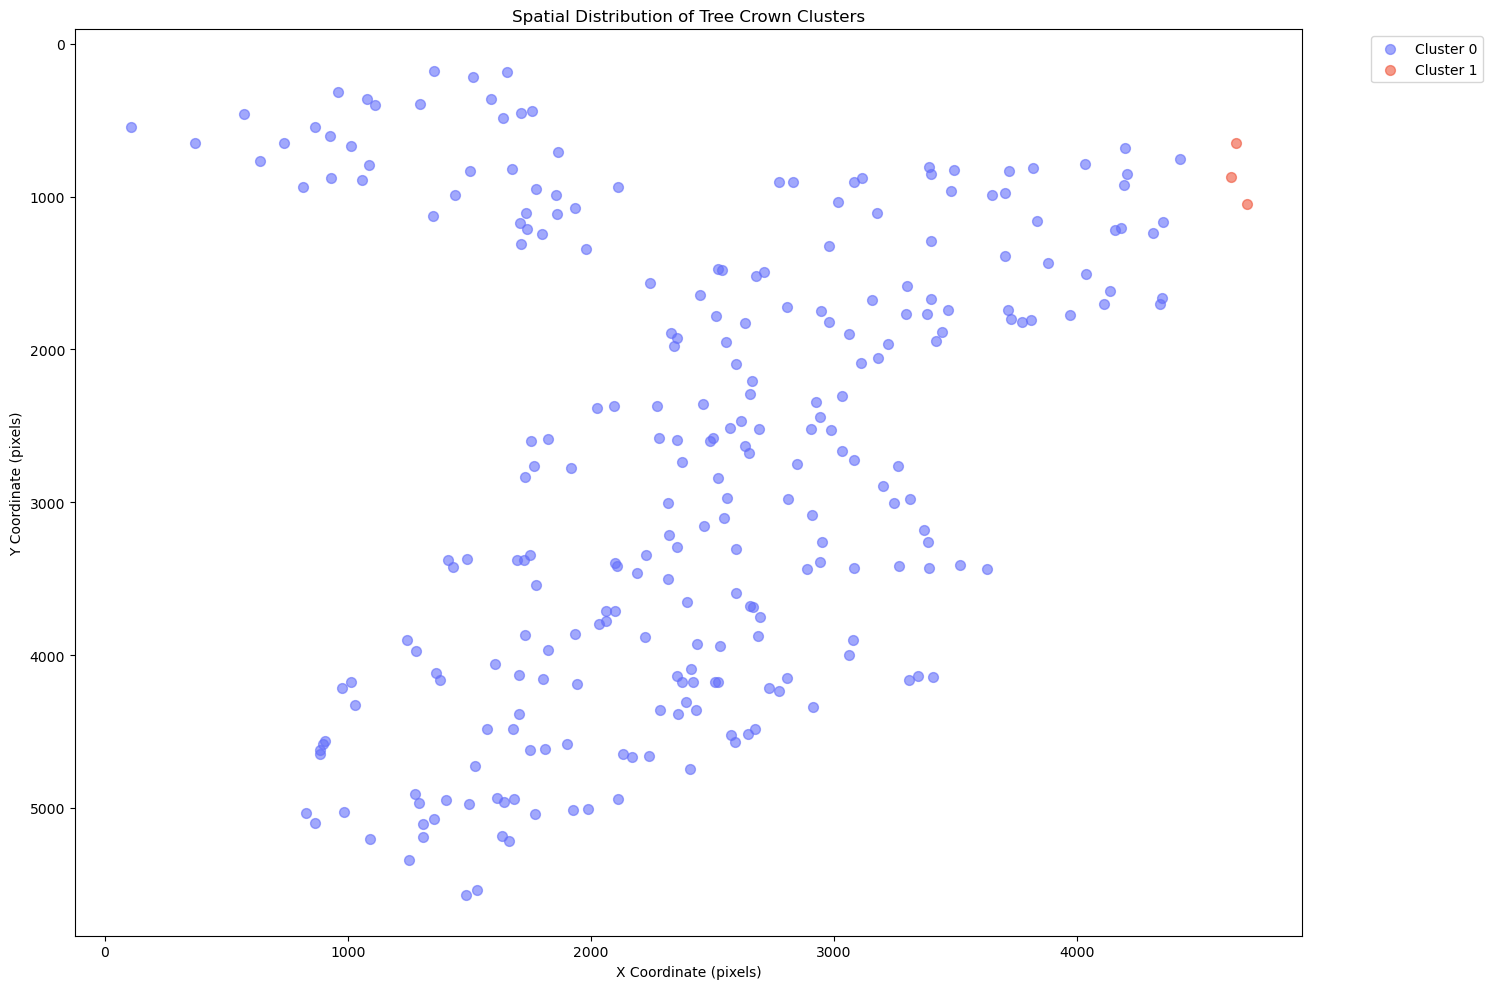

In [100]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame
df = pd.DataFrame(results_json['annotations'])

# Add centroid coordinates
df['centroid_x'] = df['global_bbox'].apply(lambda b: b[0] + b[2]/2)
df['centroid_y'] = df['global_bbox'].apply(lambda b: b[1] + b[3]/2)

# Plot spatial distribution by cluster
fig, ax = plt.subplots(figsize=(15, 10))

for cluster_id in sorted(df['cluster_id'].unique()):
    cluster_data = df[df['cluster_id'] == cluster_id]
    color = results_json['clusters'][str(cluster_id)]['color']
    label = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
    
    ax.scatter(
        cluster_data['centroid_x'],
        cluster_data['centroid_y'],
        c=color,
        label=label,
        alpha=0.6,
        s=50
    )

ax.set_xlabel('X Coordinate (pixels)')
ax.set_ylabel('Y Coordinate (pixels)')
ax.set_title('Spatial Distribution of Tree Crown Clusters')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.invert_yaxis()  # Invert Y to match image coordinates
plt.tight_layout()
plt.show()

<h4>Cluster Statistics</h4>


Confidence Statistics by Cluster:
            count     mean       std       min       25%       50%       75%  \
cluster_id                                                                     
0           258.0  0.50113  0.148513  0.300415  0.378590  0.475342  0.606345   
1             3.0  0.40526  0.050055  0.373016  0.376428  0.379841  0.421383   

                 max  
cluster_id            
0           0.905430  
1           0.462924  

Area Statistics by Cluster:
            count          mean           std      min      25%      50%  \
cluster_id                                                                 
0           258.0  75394.697674  70890.186404   5892.0  27479.5  53774.0   
1             3.0  47348.333333  12598.269140  32809.0  43506.0  54203.0   

                75%       max  
cluster_id                     
0           92781.0  489199.0  
1           54618.0   55033.0  


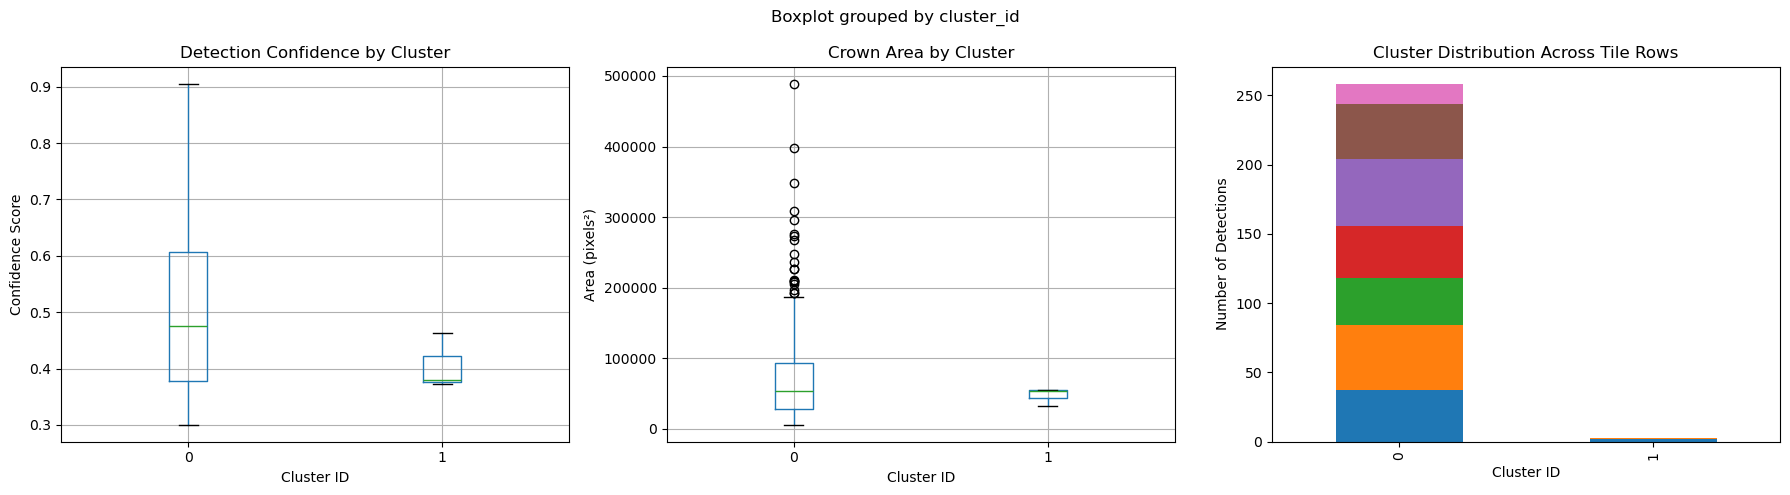

In [101]:
# Confidence statistics by cluster
print("\nConfidence Statistics by Cluster:")
print(df.groupby('cluster_id')['confidence'].describe())

print("\nArea Statistics by Cluster:")
print(df.groupby('cluster_id')['area'].describe())

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confidence distribution
df.boxplot(column='confidence', by='cluster_id', ax=axes[0])
axes[0].set_title('Detection Confidence by Cluster')
axes[0].set_xlabel('Cluster ID')
axes[0].set_ylabel('Confidence Score')

# Area distribution
df.boxplot(column='area', by='cluster_id', ax=axes[1])
axes[1].set_title('Crown Area by Cluster')
axes[1].set_xlabel('Cluster ID')
axes[1].set_ylabel('Area (pixels²)')

# Tile distribution
tile_counts = df.groupby(['cluster_id', 'tile_row']).size().unstack(fill_value=0)
tile_counts.plot(kind='bar', stacked=True, ax=axes[2], legend=False)
axes[2].set_title('Cluster Distribution Across Tile Rows')
axes[2].set_xlabel('Cluster ID')
axes[2].set_ylabel('Number of Detections')

plt.tight_layout()
plt.show()

<h4>Export Cluster-Specific Data</h4>

In [102]:
output_dir = Path(config.output_dir)

# Export each cluster to separate files
for cluster_id in df['cluster_id'].unique():
    cluster_df = df[df['cluster_id'] == cluster_id]
    
    # Save CSV
    csv_file = output_dir / f"cluster_{cluster_id}_annotations.csv"
    cluster_df.to_csv(csv_file, index=False)
    
    # Save summary stats
    stats = {
        'cluster_id': int(cluster_id),
        'count': len(cluster_df),
        'avg_confidence': float(cluster_df['confidence'].mean()),
        'avg_area': float(cluster_df['area'].mean()),
        'color': results_json['clusters'][str(cluster_id)]['color']
    }
    
    stats_file = output_dir / f"cluster_{cluster_id}_stats.json"
    import json
    with open(stats_file, 'w') as f:
        json.dump(stats, f, indent=2)

print(f"✓ Exported cluster data to {output_dir}")


✓ Exported cluster data to outputs/orthomosaic_run


<h4>Visualize Specific Tiles</h4>

In [ ]:
def visualize_tile_detections(tile_row: int, tile_col: int):
    """Visualize detections for a specific tile"""
    
    # Filter detections for this tile
    tile_id = f"tile_{tile_row}_{tile_col}"
    tile_detections = df[df['tile_id'] == tile_id]
    
    if len(tile_detections) == 0:
        print(f"No detections found in {tile_id}")
        return
    
    # Read the tile
    reader = OrthomosaicReader(config.orthomosaic_path)
    tile_rgb = reader.read_tile(tile_row, tile_col, config.tile_size)
    reader.close()
    
    # Create visualization
    plt.figure(figsize=(12, 12))
    plt.imshow(tile_rgb)
    
    for _, det in tile_detections.iterrows():
        bbox = det['local_bbox']
        cluster_id = det['cluster_id']
        color = results_json['clusters'][str(cluster_id)]['color']
        
        rect = plt.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3],
            fill=False, edgecolor=color, linewidth=2
        )
        plt.gca().add_patch(rect)
        
        # Add label
        plt.text(
            bbox[0], bbox[1] - 5,
            f"C{cluster_id}",
            color=color,
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.7)
        )
    
    plt.title(f"Tile {tile_id} - {len(tile_detections)} detections")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example: Visualize tile (0, 0)
visualize_tile_detections(0, 0)

<h4>Interactive Viewer</h4>

In [ ]:
def create_tile_viewer(results_json, config):
    """Create an interactive tile-based viewer with Plotly"""
    
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Get tile grid dimensions
    df = pd.DataFrame(results_json['annotations'])
    max_row = df['tile_row'].max()
    max_col = df['tile_col'].max()
    
    # Create heatmap of detections per tile
    tile_counts = df.groupby(['tile_row', 'tile_col']).size().reset_index(name='count')
    heatmap_data = np.zeros((max_row + 1, max_col + 1))
    
    for _, row in tile_counts.iterrows():
        heatmap_data[row['tile_row'], row['tile_col']] = row['count']
    
    # Create figure
    fig = go.Figure(data=go.Heatmap(
        z=heatmap_data,
        colorscale='Viridis',
        text=heatmap_data,
        texttemplate='%{text}',
        textfont={"size": 10},
        colorbar=dict(title="Detections")
    ))
    
    fig.update_layout(
        title="Tile-based Detection Heatmap<br><sub>Click tiles to see detail</sub>",
        xaxis_title="Tile Column",
        yaxis_title="Tile Row",
        height=600
    )
    
    return fig

tile_viewer_fig = create_tile_viewer(results_json, config)
tile_viewer_fig.show()


<h4>Performance Metrics</h4>

In [ ]:
print("\n" + "="*80)
print("PERFORMANCE SUMMARY")
print("="*80)

# Calculate processing statistics
total_tiles = metadata['total_tiles']
total_detections = len(results_json['annotations'])
avg_detections_per_tile = total_detections / total_tiles if total_tiles > 0 else 0

print(f"\nProcessing:")
print(f"  Total tiles processed: {total_tiles}")
print(f"  Average detections per tile: {avg_detections_per_tile:.1f}")

# Clustering quality
n_clusters = len([k for k in results_json['clusters'].keys() if int(k) != -1])
noise_count = results_json['clusters'].get('-1', {}).get('count', 0)
noise_ratio = noise_count / total_detections if total_detections > 0 else 0

print(f"\nClustering Quality:")
print(f"  Silhouette score: {metadata['silhouette_score']:.4f}")
print(f"  Number of clusters: {n_clusters}")
print(f"  Noise ratio: {noise_ratio:.2%}")
print(f"  Avg crowns per cluster: {total_detections / n_clusters:.1f}" if n_clusters > 0 else "  N/A")
